<a href="https://colab.research.google.com/github/HaeSeon/nlp-study/blob/main/Transformer(Attention_Is_All_You_Need)_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Vocab

sentencepiece를 이용해 vocab 을 만든다. 

한국어 위키 말뭉치를 사용한다. 

vocab을 이용해 텍스트 입력 tensor로 변경한다.

In [31]:
# !git clone https://github.com/paul-hyun/web-crawler.git
%pwd
import sentencepiece as spm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

fatal: destination path 'web-crawler' already exists and is not an empty directory.


In [29]:
%cd /content/

/content


In [32]:

# vocab loading
vocab_file = "kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[3159, 3533,  200, 3883, 3688, 3519,    0,    0],
        [ 206, 3534,   53, 3759, 3525, 3613, 3688, 3519]])


# 2. Embedding

transformer의 embedding은 Input Embedding과 Position Embedding 두가지를 합쳐서 사용한다. 

embedding은 입력 토큰을 vector 형태로 변환한다. 

**Input embedding**

In [33]:
# inputs에 대한 embedding 값 input_embs를 구한다. 
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
# 위와같이 inputs(2,8)에 대한 embedding값 input_embs(2,8,128) shape을 갖는다. 
print(input_embs.size())

torch.Size([2, 8, 128])


**Position Embedding**

Position encoding값을 구하기 위한 함수는 아래와 같다. 

1. 각 position별도 angle 값을 구합니다.
2. 구해진 angle 중 짝수 index의 값에 대한 sin 값을 구합니다.
3. 구해진 angle 중 홀수 index의 값에 대한 cos 값을 구합니다.

In [34]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

(64, 128)


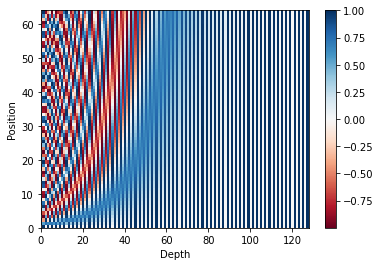

In [35]:
# position encoding 구하기
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

아래의 방식으로 position embedding 값을 구한다.

1. 위해서 구해진 position encodong 값을 이용해 position emgedding을 생성합니다. 학습되는 값이 아니므로 freeze옵션을 True로 설정 합니다.
2. 입력 inputs과 동일한 크기를 갖는 positions값을 구합니다.
3. input값 중 pad(0)값을 찾습니다.
4. positions값중 pad부분은 0으로 변경 합니다.
5. positions값에 해당하는 embedding값을 구합니다.

In [36]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3159, 3533,  200, 3883, 3688, 3519,    0,    0],
        [ 206, 3534,   53, 3759, 3525, 3613, 3688, 3519]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


In [37]:
# transformer에 입력할 input
input_sums = input_embs + pos_embs

# 3. Scaled Dot Product Attention
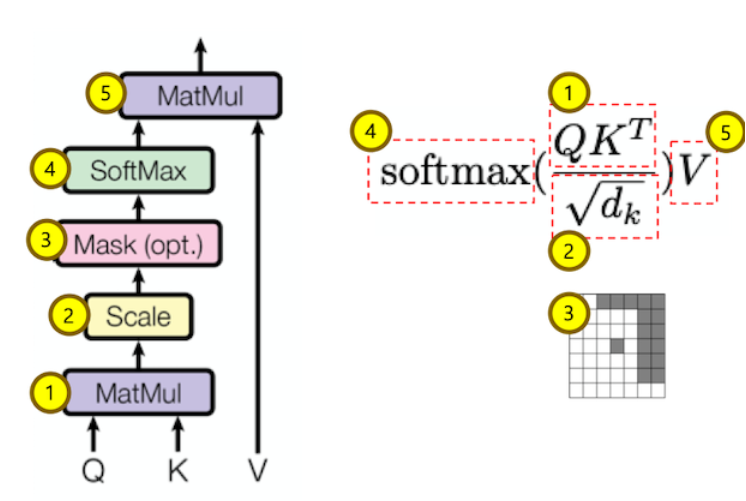

**입력값**

입력값은 Q(query), K(key), V(value) 그리고 attention mask로 구성.
입력값 중 K, V는 같은 값 이어야 한다. 
Q, K, V가 모두 동일한 경우는 self attention이라 한다. 

In [38]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


**MatMul Q, K-transpose**

In [39]:
#  1번 Q * K-transpose를 하는 코드
# 각 단어상호간에 가중치를 표현하는 테이블이 생성되었다. 
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[187.9480,  45.9473,  62.4443,  61.0948,  61.1852,  25.3092,  47.6880,
          47.6880],
        [ 45.9473, 150.8507,  62.6132,  50.6640,  60.6662,   7.4061,  17.0965,
          17.0965],
        [ 62.4443,  62.6132, 159.0150,  69.2827,  64.5422,  74.1018,  35.3692,
          35.3692],
        [ 61.0948,  50.6640,  69.2827, 175.4608,  66.7059,  42.2668,  47.5254,
          47.5254],
        [ 61.1852,  60.6662,  64.5422,  66.7059, 198.9492,  73.2436,  36.1952,
          36.1952],
        [ 25.3092,   7.4061,  74.1018,  42.2668,  73.2436, 202.0375,  25.1286,
          25.1286],
        [ 47.6880,  17.0965,  35.3692,  47.5254,  36.1952,  25.1286, 175.1859,
         175.1859],
        [ 47.6880,  17.0965,  35.3692,  47.5254,  36.1952,  25.1286, 175.1859,
         175.1859]], grad_fn=<SelectBackward>)


**Scale**

2번 k-dimension에 루트를 취한 값으로 나누는 코드


In [40]:
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])
# 위 값에 비해 가중치 편차가 줄어든 것을 확인 할 수 있다. 

torch.Size([2, 8, 8])
tensor([[23.4935,  5.7434,  7.8055,  7.6369,  7.6482,  3.1636,  5.9610,  5.9610],
        [ 5.7434, 18.8563,  7.8267,  6.3330,  7.5833,  0.9258,  2.1371,  2.1371],
        [ 7.8055,  7.8267, 19.8769,  8.6603,  8.0678,  9.2627,  4.4211,  4.4211],
        [ 7.6369,  6.3330,  8.6603, 21.9326,  8.3382,  5.2833,  5.9407,  5.9407],
        [ 7.6482,  7.5833,  8.0678,  8.3382, 24.8687,  9.1555,  4.5244,  4.5244],
        [ 3.1636,  0.9258,  9.2627,  5.2833,  9.1555, 25.2547,  3.1411,  3.1411],
        [ 5.9610,  2.1371,  4.4211,  5.9407,  4.5244,  3.1411, 21.8982, 21.8982],
        [ 5.9610,  2.1371,  4.4211,  5.9407,  4.5244,  3.1411, 21.8982, 21.8982]],
       grad_fn=<SelectBackward>)


**Mask**

3번 mask 하는 코드

In [41]:
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])
# mask를 한 부분이 -1e9로 매우 작은 값으로 변경된 것을 확인 할 수 있다.

torch.Size([2, 8, 8])
tensor([[ 2.3493e+01,  5.7434e+00,  7.8055e+00,  7.6369e+00,  7.6482e+00,
          3.1636e+00, -1.0000e+09, -1.0000e+09],
        [ 5.7434e+00,  1.8856e+01,  7.8267e+00,  6.3330e+00,  7.5833e+00,
          9.2576e-01, -1.0000e+09, -1.0000e+09],
        [ 7.8055e+00,  7.8267e+00,  1.9877e+01,  8.6603e+00,  8.0678e+00,
          9.2627e+00, -1.0000e+09, -1.0000e+09],
        [ 7.6369e+00,  6.3330e+00,  8.6603e+00,  2.1933e+01,  8.3382e+00,
          5.2833e+00, -1.0000e+09, -1.0000e+09],
        [ 7.6482e+00,  7.5833e+00,  8.0678e+00,  8.3382e+00,  2.4869e+01,
          9.1555e+00, -1.0000e+09, -1.0000e+09],
        [ 3.1636e+00,  9.2576e-01,  9.2627e+00,  5.2833e+00,  9.1555e+00,
          2.5255e+01, -1.0000e+09, -1.0000e+09],
        [ 5.9610e+00,  2.1371e+00,  4.4211e+00,  5.9407e+00,  4.5244e+00,
          3.1411e+00, -1.0000e+09, -1.0000e+09],
        [ 5.9610e+00,  2.1371e+00,  4.4211e+00,  5.9407e+00,  4.5244e+00,
          3.1411e+00, -1.0000e+09, -1.0000e

**Softmax**

In [42]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])
# 가중치가 확률로 변환 된 값을 볼 수 있다. 
# mask를 한 부분이 모두 0이 되었다.

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 1.9554e-08, 1.5375e-07, 1.2988e-07, 1.3136e-07, 1.4820e-09,
         0.0000e+00, 0.0000e+00],
        [2.0189e-06, 9.9997e-01, 1.6213e-05, 3.6405e-06, 1.2710e-05, 1.6324e-08,
         0.0000e+00, 0.0000e+00],
        [5.7208e-06, 5.8429e-06, 9.9994e-01, 1.3449e-05, 7.4361e-06, 2.4564e-05,
         0.0000e+00, 0.0000e+00],
        [6.1864e-07, 1.6795e-07, 1.7216e-06, 1.0000e+00, 1.2475e-06, 5.8792e-08,
         0.0000e+00, 0.0000e+00],
        [3.3207e-08, 3.1121e-08, 5.0521e-08, 6.6211e-08, 1.0000e+00, 1.4991e-07,
         0.0000e+00, 0.0000e+00],
        [2.5467e-10, 2.7169e-11, 1.1344e-07, 2.1211e-09, 1.0190e-07, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.9786e-01, 8.6898e-03, 8.5305e-02, 3.8985e-01, 9.4584e-02, 2.3716e-02,
         0.0000e+00, 0.0000e+00],
        [3.9786e-01, 8.6898e-03, 8.5305e-02, 3.8985e-01, 9.4584e-02, 2.3716e-02,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward>)


**MatMul attn_prov, V**

5번 attn_prov * V를 하는 코드

In [43]:
context = torch.matmul(attn_prob, V)
print(context.size())
# Q와 동일한 shape 값이 구해진다. 
# 이 값은 V값들이 attn_prov의 가중치를 이용해서 더해진 값 이다.

torch.Size([2, 8, 128])


**Class**

위 절차를 하나의 클래스로 구성하면 아래와 같다. 

In [44]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

# 4. Multi-Head Attention

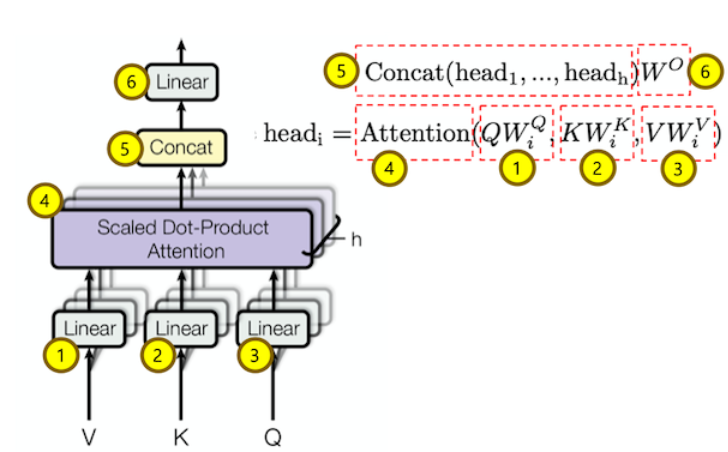

**입력값**

Q, K, V, attn_mask는 ScaledDotProductAttention과 동일

head 개수는 2개 head의 dimension은 64

In [45]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

**Multi Head Q, K, V**

1. Q를 여러개의 head로 나누는 과정

In [47]:
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())
# Q, K, V 모두 Multi Head로 나눠졌다.

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


In [48]:
# Attention Mask도 Multi Head로 변경
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


**Attention**

4. Attention과정 - Scaled Dot Product Attention’을 사용

In [49]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


**Concat**

5. Concat 과정

In [50]:
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())
# multi dead를 하나로 합쳤다. 

torch.Size([2, 8, 128])


**Linear**

6. Linear과정

In [51]:
linear = nn.Linear(n_head * d_head, d_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())
# 입력 Q와 동일한 shape을 가진 multi head attention이 구해졌다. 

torch.Size([2, 8, 128])


**Class**

위 절차를 하나의 클래스로 구현하면 아래와 같다. 

In [52]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

# 5. Masked Multi-Head Attention

Masked Multi-Head Attention은 Multi-Head Attention과 attention mask를 제외한 부분은 모두 동일하다. 

**입력값**

In [53]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2
# pad mask, decoder mask 그리고 이 둘을 합한 attention mask를 확인 할 수 있다. 

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],


**Multi-Head Attention**

Multi-Head Attention과 동일하므로 위에서 선언한 MultiHeadAttention 클래스를 바로 호출한다. 

In [54]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


# 6. FeedForward

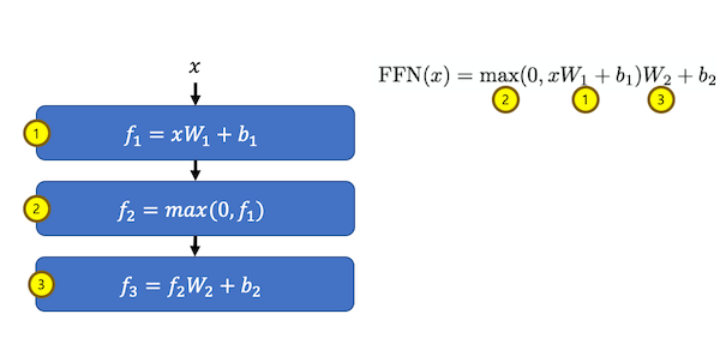

**1. linear**

In [55]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())
# 입력에 비해 hidden simension이 4배 커졌다. 

torch.Size([2, 512, 8])


**2. Activation (relu or gelu)**

In [56]:
# active = F.relu
active = F.gelu
ff_2 = active(ff_1)

**3. f3(Linear)**

In [57]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 8, 128])


**Class**

위 절차를 하나의 클래스로 구성하면 아래와 같다. 

In [58]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output